In [36]:
import os
import sys
work_dir = '/home/abhijit/nat/Object-Detection'
data_dir = work_dir+'/data/'
util_dir = work_dir+'/data_utilities/'
os.chdir(work_dir)
sys.path.append(util_dir)
sys.path.append(data_dir)

import wv_util as wv
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline
from PIL import Image, ImageDraw 
from tqdm import tqdm
import pickle
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from matplotlib.lines import Line2D
import pandas as pd
from read_write import *
import shutil
from torch.utils.data import random_split
import torch.nn as nn

In [2]:
#Loading our labels
coords, chips, classes = wv.get_labels(data_dir+'xView_train.geojson')

100%|██████████| 601937/601937 [00:03<00:00, 187330.02it/s]


In [3]:
labels = {}
with open(util_dir+'xview_class_labels.txt') as f:
    for row in csv.reader(f):
        labels[int(row[0].split(":")[0])] = row[0].split(":")[1]

valid_labels = list(labels.keys())

In [4]:
valid_chip_names = load("valid_chip_names.pkl")

id2label = load("class_to_label_map.pkl")

label2id = {v:k for k,v in id2label.items()}

len(id2label)

60

In [5]:
def label2idx(labels):
    return {label:label2id[label] for label in labels}

In [6]:
label2idx(['Pickup Truck','Truck Tractor','Truck w/Flatbed','Truck w/Liquid'])

{'Pickup Truck': '20',
 'Truck Tractor': '26',
 'Truck w/Flatbed': '28',
 'Truck w/Liquid': '29'}

In [7]:
unique, counts = np.unique(classes, return_counts=True)
class_counts = {k:0 for k in list(unique.astype('int64'))}

In [8]:
transform=transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor()])

dataset = ImageFolder(data_dir+'train_images_24classes_split/train',transform=transform,)

#trainset, valset = random_split(dataset, [189829, 81355])

trainloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

In [9]:
np.unique(dataset.targets,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([  2052, 147347,   4824,    767,   2518,   8461,   4096,   2513,
           599,   2839,    620,   1117,   1274,   1018,    510,    945,
           585,    492,    801,    718,   2229,   1126,   1266,   1101]))

In [10]:
len(dataset.targets)

189818

In [11]:
labels1 = [id2label[idx_to_class[i]] for i in range(len(dataset.classes))]

In [12]:
labels1

['Passenger Vehicle',
 'Small Car',
 'Bus',
 'Pickup Truck',
 'Utility Truck',
 'Truck',
 'Cargo Truck',
 'Truck w/Box',
 'Truck Tractor',
 'Trailer',
 'Truck w/Flatbed',
 'Passenger Car',
 'Cargo Car',
 'Motorboat',
 'Fishing Vessel',
 'Dump Truck',
 'Excavator',
 'Hut/Tent',
 'Shed',
 'Damaged Building',
 'Vehicle Lot',
 'Storage Tank',
 'Shipping container lot',
 'Shipping Container']

In [13]:
dataset.classes

['17',
 '18',
 '19',
 '20',
 '21',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '34',
 '35',
 '41',
 '47',
 '60',
 '64',
 '71',
 '72',
 '76',
 '83',
 '86',
 '89',
 '91']

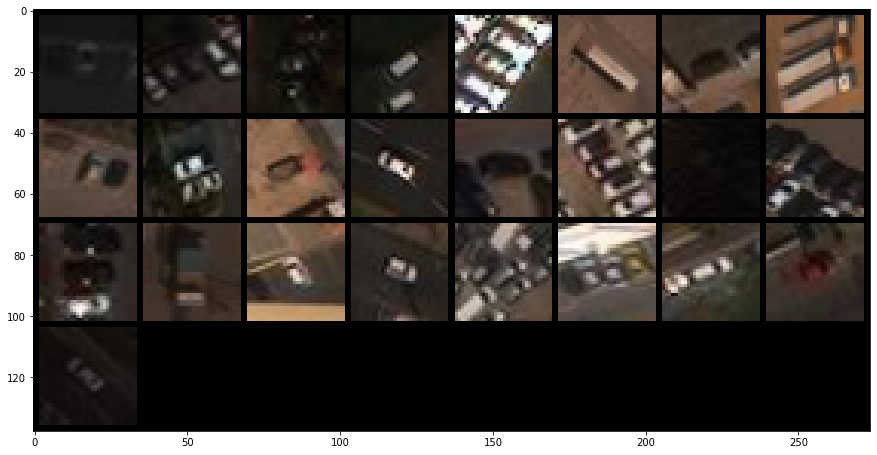

In [14]:
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=[15,10])
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
show(img_grid)

In [15]:
train_size = 0.7*len(dataset)
val_size = 0.3*len(dataset)
print("full size",len(dataset))
print("train size",train_size)
print("val size",val_size)
189829+81355

full size 189818
train size 132872.6
val size 56945.4


271184

In [16]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
def plot_classes_preds(images, labels):
    
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 10))
    for idx in np.arange(len(images)):
        ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
        ax.set_title(id2label[idx_to_class[labels[idx].item()]])
        matplotlib_imshow(images[idx])
    return fig
#writer = SummaryWriter('runs/Object_detection_experiment_'+str(np.random.randint(0,1000)),flush_secs=1)
#writer.add_figure('Images and labels', plot_classes_preds(images, labels))

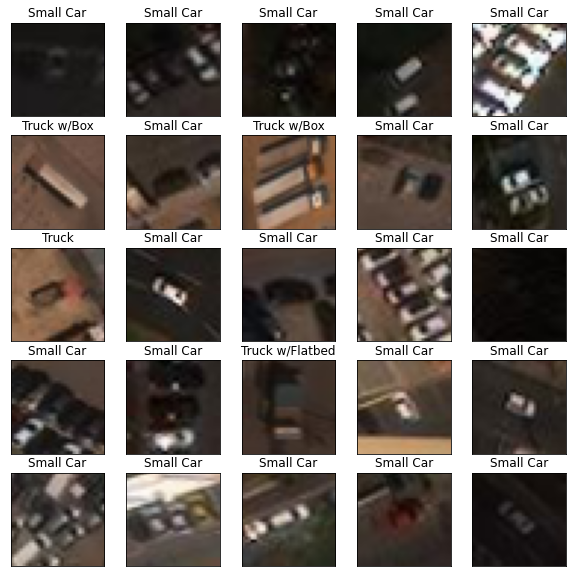

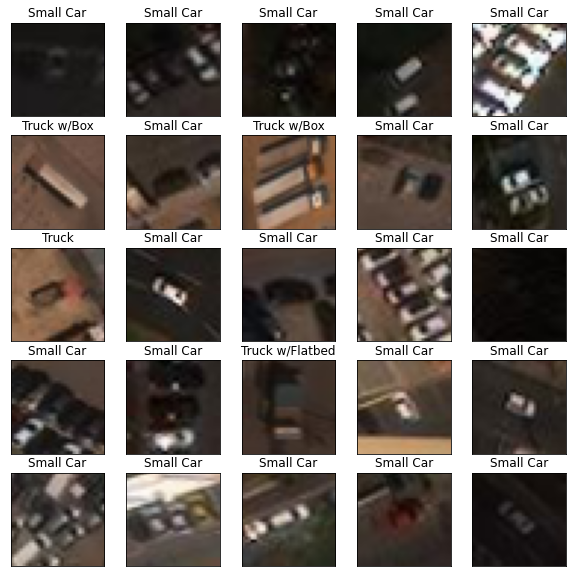

In [17]:
plot_classes_preds(images, labels)

In [18]:
total_num_of_images = 0
class_counts = {}
for subdir, dirs, files in os.walk(data_dir+'train_images_24classes'):
    if len(files)>0:
        print(f'{id2label.get(subdir[-2:],-1):>25} {len(files):>10}')
        class_counts[id2label.get(subdir[-2:],-1)] = len(files)
        total_num_of_images+=len(files)
print(total_num_of_images)

              Cargo Truck       5852
              Vehicle Lot       3185
                Cargo Car       1820
             Pickup Truck       1096
              Truck w/Box       3591
                     Shed       1145
         Damaged Building       1026
               Dump Truck       1351
                 Hut/Tent        703
                      Bus       6892
            Passenger Car       1596
                Small Car     210497
             Storage Tank       1609
       Shipping Container       1574
            Truck Tractor        856
        Passenger Vehicle       2932
           Fishing Vessel        729
   Shipping container lot       1809
                Motorboat       1455
            Utility Truck       3598
          Truck w/Flatbed        887
                  Trailer       4057
                Excavator        836
                    Truck      12088
271184


In [19]:
147347+63150

210497

In [20]:
63150/81366

0.7761227048152791

In [21]:
81366/271184

0.3000398253584282

In [22]:
c_count = pd.DataFrame(list(class_counts.values()))
c_count[c_count[0]>700].values[1:]
small_subset_class = {}
a = 0
for label, count in class_counts.items():
    
    if count > 700 and count < 250000:
        small_subset_class[label] = count
        #print(label,count)
        a+=count
print("total",a)
print(small_subset_class)
print("total confirm",sum(list(small_subset_class.values())))
print("len",len(small_subset_class))
#save('class_counts_24classes.pkl',small_subset_class)

total 271184
{'Cargo Truck': 5852, 'Vehicle Lot': 3185, 'Cargo Car': 1820, 'Pickup Truck': 1096, 'Truck w/Box': 3591, 'Shed': 1145, 'Damaged Building': 1026, 'Dump Truck': 1351, 'Hut/Tent': 703, 'Bus': 6892, 'Passenger Car': 1596, 'Small Car': 210497, 'Storage Tank': 1609, 'Shipping Container': 1574, 'Truck Tractor': 856, 'Passenger Vehicle': 2932, 'Fishing Vessel': 729, 'Shipping container lot': 1809, 'Motorboat': 1455, 'Utility Truck': 3598, 'Truck w/Flatbed': 887, 'Trailer': 4057, 'Excavator': 836, 'Truck': 12088}
total confirm 271184
len 24


In [23]:
new_classes = load('class_counts_24classes.pkl')
#os.mkdir(data_dir+'train_images_24classes')
# for i in list(new_classes.keys()):
#     os.mkdir(data_dir+'train_images_24classes/'+str(int(label2id[i])))

In [24]:
a

271184

In [25]:
np.round(2.3444,2)

2.34

In [26]:
label2id

{'Fixed-wing Aircraft': '11',
 'Small Aircraft': '12',
 'Cargo Plane': '13',
 'Helicopter': '15',
 'Passenger Vehicle': '17',
 'Small Car': '18',
 'Bus': '19',
 'Pickup Truck': '20',
 'Utility Truck': '21',
 'Truck': '23',
 'Cargo Truck': '24',
 'Truck w/Box': '25',
 'Truck Tractor': '26',
 'Trailer': '27',
 'Truck w/Flatbed': '28',
 'Truck w/Liquid': '29',
 'Crane Truck': '32',
 'Railway Vehicle': '33',
 'Passenger Car': '34',
 'Cargo Car': '35',
 'Flat Car': '36',
 'Tank car': '37',
 'Locomotive': '38',
 'Maritime Vessel': '40',
 'Motorboat': '41',
 'Sailboat': '42',
 'Tugboat': '44',
 'Barge': '45',
 'Fishing Vessel': '47',
 'Ferry': '49',
 'Yacht': '50',
 'Container Ship': '51',
 'Oil Tanker': '52',
 'Engineering Vehicle': '53',
 'Tower crane': '54',
 'Container Crane': '55',
 'Reach Stacker': '56',
 'Straddle Carrier': '57',
 'Mobile Crane': '59',
 'Dump Truck': '60',
 'Haul Truck': '61',
 'Scraper/Tractor': '62',
 'Front loader/Bulldozer': '63',
 'Excavator': '64',
 'Cement Mixer

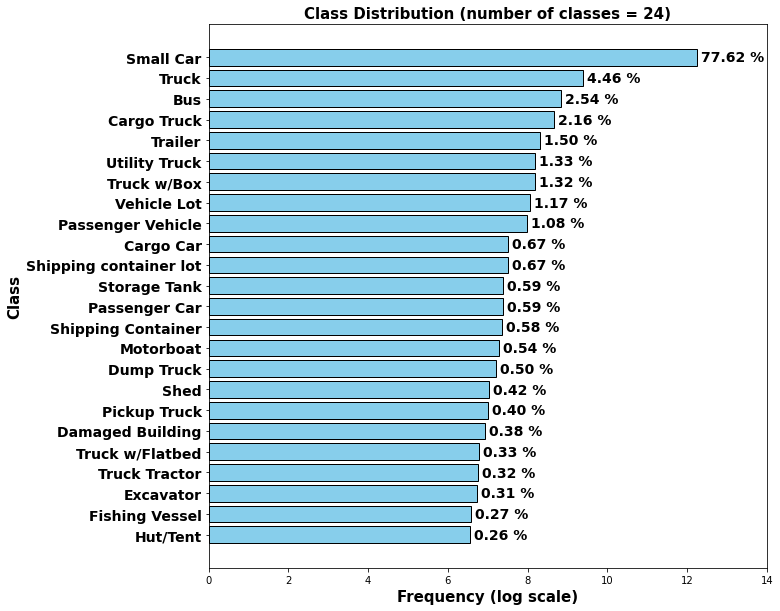

In [27]:
fig, ax = plt.subplots(figsize=[10,10])
class_counts = sorted(class_counts.items(), key=lambda class_counts: class_counts[1])
class_counts = {k: v for k, v in class_counts}
real_count = list(class_counts.values())
total_count = np.sum(real_count)
bars = plt.barh(list(class_counts.keys()), np.log(np.array(list(class_counts.values()))), edgecolor='k',color='skyblue')

for i,bar in enumerate(bars): 
    width = bar.get_width() +0.1
    label_y_pos = bar.get_y() + 0.2 + bar.get_height() // 2
    #ax.text(width,label_y_pos, s=f'{real_count[i]}',fontweight='bold',fontdict={'fontsize':14})
    ax.text(width,label_y_pos, s=f'{np.round(1.0*real_count[i]/total_count,4)*100.0:.2f} %',fontweight='bold',fontdict={'fontsize':14})
    
    if i > 44:
        bar.set_color('#8f9805')
        bar.set_edgecolor('k')

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14)
    tick.label1.set_fontweight('bold')

custom_lines = [Line2D([0], [0], color='#8f9805', lw=4)]
#plt.legend(custom_lines,['Top 15 most frequent classes'],loc=5,fontsize='large')
plt.title('Class Distribution (number of classes = ' + str(len(real_count))+')',fontdict={'fontsize':15,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':15,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':15,'fontweight':'bold'})
plt.xlim(0,14)

plt.show()

In [ ]:
plt.savefig('test_saving1.png')

In [ ]:
fig.savefig('test_saving2.png', bbox_inches='tight')

In [ ]:
save_plot_directory = os.path.join('./runs', os.sep, 'resnet50',os.sep,'blah')

In [ ]:
save_plot_directory

In [ ]:
f = open('old_pixel_areas.pkl','rb')
old_pixel_areas = pickle.load(f)
plt.figure(figsize=[10,6])
plt.hist(np.log(np.array(old_pixel_areas)),bins=50,color='skyblue',ec="k")

plt.title('Histogram of pixel areas before resampling \n Total number of images = 593,091',fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':14,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlim(5,14)

plt.show()

In [ ]:
f = open('new_pixel_areas.pkl','rb')
new_pixel_areas = pickle.load(f)
plt.figure(figsize=[10,6])
plt.hist(np.log(np.array(new_pixel_areas)),bins=20,color='skyblue',ec="k")

plt.title('Histogram of pixel areas after resampling \n Total number of images = 581,470',fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlabel('Frequency (log scale)', fontdict={'fontsize':14,'fontweight':'bold'})
plt.ylabel('Class', fontdict={'fontsize':14,'fontweight':'bold'})
plt.xlim(5,14)

plt.show()

In [ ]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(data_dir+'train_images_24classes/', output=data_dir+'train_images_24classess_split', seed=1337, ratio=(.7, .3), group_prefix=None) # default values

# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
#splitfolders.fixed("input_folder", output="output", seed=1337, fixed=(100, 100), oversample=False, group_prefix=None) # default values

In [ ]:
!pwd

In [ ]:
!pip install split-folders

In [ ]:
data_dir+'train_images_24classess_split'

In [ ]:
splitfolders.ratio()

In [ ]:
import torch.nn as nn

net = nn.Sequential(nn.Linear(20, 6), nn.Linear(6, 3))

In [ ]:
net[0]

In [ ]:
from models.resnet import resnet50

In [ ]:
net = resnet50()

In [ ]:
net

In [ ]:
for name,param in net.named_parameters():
    print(name)

In [ ]:
list(net.children())[-1].named

In [ ]:
net.train()

In [ ]:
input_tensor = torch.Tensor(10, 3, 64, 64)

In [ ]:
net = net.cuda()
output = net(input_tensor)

In [ ]:
a, b = output.max(1)

In [ ]:
b.tolist()

In [ ]:
f = []

In [ ]:
f.extend(b.tolist())

In [ ]:
f

In [ ]:
images, labels = next(iter(trainloader))

In [ ]:
images.shape

In [ ]:
labels

In [ ]:
labels.tolist()

In [ ]:
!nvidia-msi

In [ ]:
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0.0, 0.0, 0
    
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
        
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    
    return mean, std

In [ ]:
get_mean_std(trainloader)

In [ ]:
trainloader_new = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [ ]:
a = next(iter(trainloader_new))

In [ ]:
img, labels = a

In [ ]:
img.mean([0,2,3])

In [ ]:
img.std([0,2,3])

In [ ]:
x = torch.Tensor(5,3,4,4)

In [ ]:
torch.mean(x,[0,2,3])

In [ ]:
torch.mean(x[:,2,:,:])

In [ ]:
y

In [51]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
resnet50 = torchvision.models.resnet50(pretrained=True)

In [52]:
print(f'{"model":<35} {"requires grad":<10}')
for name, param in resnet50.named_parameters():
    print(f'{name:<35} {str(param.requires_grad):<10}')

model                               requires grad
conv1.weight                        True      
bn1.weight                          True      
bn1.bias                            True      
layer1.0.conv1.weight               True      
layer1.0.bn1.weight                 True      
layer1.0.bn1.bias                   True      
layer1.0.conv2.weight               True      
layer1.0.bn2.weight                 True      
layer1.0.bn2.bias                   True      
layer1.0.conv3.weight               True      
layer1.0.bn3.weight                 True      
layer1.0.bn3.bias                   True      
layer1.0.downsample.0.weight        True      
layer1.0.downsample.1.weight        True      
layer1.0.downsample.1.bias          True      
layer1.1.conv1.weight               True      
layer1.1.bn1.weight                 True      
layer1.1.bn1.bias                   True      
layer1.1.conv2.weight               True      
layer1.1.bn2.weight                 True      
layer1.1.b

In [37]:
for param in resnet50.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)

In [50]:
print(f'{"model":<35} {"requires grad":<10}')
for name, param in resnet50.named_parameters():
    print(f'{name:<35} {str(param.requires_grad):<10}')

model                               requires grad
conv1.weight                        False     
bn1.weight                          False     
bn1.bias                            False     
layer1.0.conv1.weight               False     
layer1.0.bn1.weight                 False     
layer1.0.bn1.bias                   False     
layer1.0.conv2.weight               False     
layer1.0.bn2.weight                 False     
layer1.0.bn2.bias                   False     
layer1.0.conv3.weight               False     
layer1.0.bn3.weight                 False     
layer1.0.bn3.bias                   False     
layer1.0.downsample.0.weight        False     
layer1.0.downsample.1.weight        False     
layer1.0.downsample.1.bias          False     
layer1.1.conv1.weight               False     
layer1.1.bn1.weight                 False     
layer1.1.bn1.bias                   False     
layer1.1.conv2.weight               False     
layer1.1.bn2.weight                 False     
layer1.1.b

In [53]:
resnet50.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)